<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/FLOPS/Alexnet%20TL%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile

In [2]:
# Download dataset dari Kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
100% 161M/161M [00:08<00:00, 24.8MB/s]
100% 161M/161M [00:08<00:00, 20.4MB/s]


In [3]:
# Image size
IMAGE_SIZE = 227

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Function to make data
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img_list.append(path)
        label_list.append(label)

# Dataset directory
dataset_dir = '/content/data'

# Lists to hold image paths and labels
image_paths = []
labels = []

# Load data
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(i, class_dir, image_paths, labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

100%|██████████| 1146/1146 [00:00<00:00, 335989.96it/s]


In [4]:
# Split data into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Datasets and dataloaders
train_dataset = CustomDataset(train_paths, train_labels, transform=data_transforms['train'])
val_dataset = CustomDataset(test_paths, test_labels, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [5]:
# Model
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

# Freeze all the parameters in the feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(le.classes_))

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=50):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+ 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=100)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 110MB/s] 


Epoch 1/100
----------
train Loss: 0.6779 Acc: 0.7588
val Loss: 0.4009 Acc: 0.8568

Epoch 2/100
----------
train Loss: 0.3784 Acc: 0.8654
val Loss: 0.3289 Acc: 0.8807

Epoch 3/100
----------
train Loss: 0.3195 Acc: 0.8887
val Loss: 0.2966 Acc: 0.8902

Epoch 4/100
----------
train Loss: 0.2860 Acc: 0.9003
val Loss: 0.2747 Acc: 0.9069

Epoch 5/100
----------
train Loss: 0.2620 Acc: 0.9015
val Loss: 0.2660 Acc: 0.9010

Epoch 6/100
----------
train Loss: 0.2559 Acc: 0.8994
val Loss: 0.2525 Acc: 0.9129

Epoch 7/100
----------
train Loss: 0.2448 Acc: 0.9072
val Loss: 0.2454 Acc: 0.9129

Epoch 8/100
----------
train Loss: 0.2383 Acc: 0.9054
val Loss: 0.2422 Acc: 0.9057

Epoch 9/100
----------
train Loss: 0.2175 Acc: 0.9167
val Loss: 0.2342 Acc: 0.9141

Epoch 10/100
----------
train Loss: 0.2235 Acc: 0.9140
val Loss: 0.2323 Acc: 0.9141

Epoch 11/100
----------
train Loss: 0.2082 Acc: 0.9221
val Loss: 0.2240 Acc: 0.9153

Epoch 12/100
----------
train Loss: 0.2040 Acc: 0.9203
val Loss: 0.2207 Ac

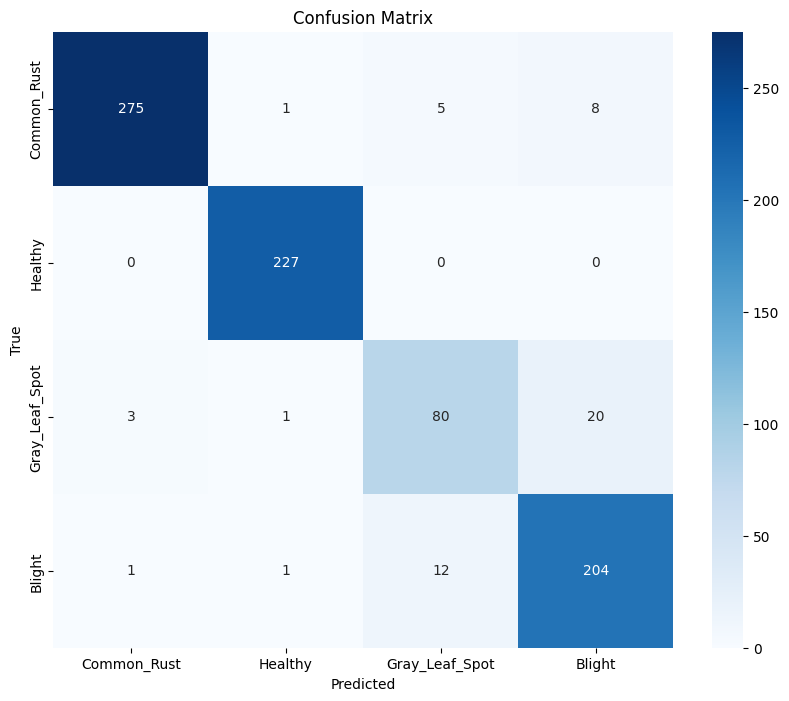


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       289
           1       0.99      1.00      0.99       227
           2       0.82      0.77      0.80       104
           3       0.88      0.94      0.91       218

    accuracy                           0.94       838
   macro avg       0.92      0.91      0.92       838
weighted avg       0.94      0.94      0.94       838



In [6]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = [str(cls) for cls in le.classes_]
class_report = classification_report(all_labels, all_preds, target_names=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(class_report)

In [7]:
torch.save(model.state_dict(), 'alexnetTL.pth')

In [11]:
model = models.alexnet()

input = torch.randn(1, 3, 227, 227)

flops, params = profile(model, inputs=(input, ))
print(f"Estimasi FLOPS: {flops}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Estimasi FLOPS: 716785664.0
